In [1]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
from misc import get_attr
import time
pd.set_option('mode.chained_assignment', None)
from framework import tester, strategy
from environments.gym_env import TradingEnv



In [2]:
spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218206,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY
...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY


c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


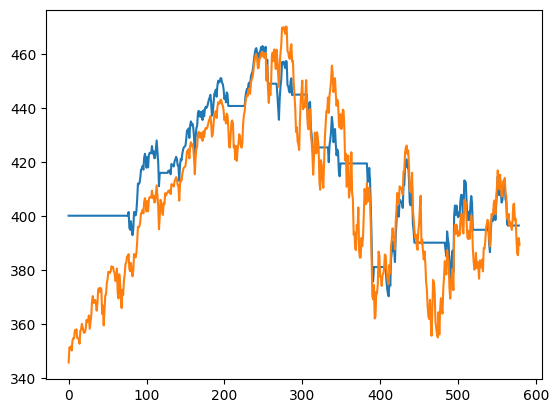

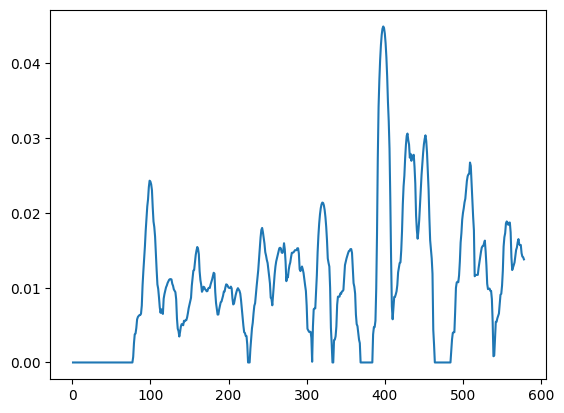

In [3]:
class ma_crossover_policy:
    def __init__(self):
        pass
    def learn(self, timesteps):
        pass
    def predict(self, obs, deterministic=False, **kwargs):
        '''
        input_arr = ADJC, S, S+1
        trader_state = cash, position, position_value, portfolio_value, margin
        '''
        buy_threshold = get_attr(kwargs, 'buy_threshold', 0)
        sell_threshold = get_attr(kwargs, 'sell_threshold', 0)
        cash, position, _, _, _, _ = obs[-6:]
        adjclose, signal, signal_1 = obs[:3]

        # print(cash, position)
        

        limit_order = np.zeros(2)
        if  signal > buy_threshold and signal_1 < buy_threshold:
            limit_order[0] = adjclose
            limit_order[1] = cash // adjclose
        elif signal < sell_threshold and signal_1 > sell_threshold:
            limit_order[0] = adjclose
            limit_order[1] = -position
        # print(limit_order)
        return limit_order, None

def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df[-600:].copy()
df = ma_signal(df)
params = {
    'initial_capital': 1e6,
    'input_feature_list': ['adjclose', 'signal', 'signal+1']
}

# tdf = tdf[['date', 'adjclose', 'signal', 'signal+1']]


env = TradingEnv(df, **params)

# model = PPO(policy = "MlpPolicy",env=env, verbose=3, device='cuda')
# model.learn(total_timesteps=25000)

model = ma_crossover_policy()

obs = env.reset()
for i in range(600):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
    #   obs = env.reset()
      break

# print(env.records['portfolio_volatility'])

In [4]:

# model = PPO(policy = "MlpPolicy",env=env, verbose=3, device='cuda')
# model.learn(total_timesteps=25000)

# obs = env.reset()
# for i in range(600):
#     action, _state = model.predict(obs, deterministic=True)
#     obs, reward, done, info = env.step(action)
#     env.render()
#     if done:
#     #   obs = env.reset()
#       break


In [6]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''
        Save a transition
        '''
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

In [92]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.shape[0]
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy_net(state)
    else:
        action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
    
    return action.view(1, 2)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # plot 100 episode averages
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())



In [101]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(S_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters, 100)
    optimizer.step()


In [102]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    print(f'episode:{i_episode}')
    # initialise env
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        print(f'steps: {t}')
        action = select_action(state)
        np_action = action.detach().numpy()[0]
        print(np_action)
        observation, reward, terminated, _ = env.step(np_action)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # store the transition in memory
        memory.push(state, action, next_state, reward)

        # move to next state
        state = next_state

        # perform one step of the optimisation (on the policy network)
        optimize_model()

        # soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t+1)
            plot_durations()
            break

print('complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

episode:0
steps: 0
[     169 13416567]


C:\Users\alexr\AppData\Local\Temp\ipykernel_15792\2943377702.py:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RuntimeError: gather(): Expected dtype int64 for index

In [91]:
a = torch.tensor([[[       376, -172506561]]])
print(a)
print(a.view(1, 2))
b = torch.tensor([[20260.3945],[ 8213.6328]])
print(b.view(1, 2))

tensor([[[       376, -172506561]]])
tensor([[       376, -172506561]])
tensor([[20260.3945,  8213.6328]])
